In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib
import pickle
from scipy.stats import median_abs_deviation, hypergeom
import math

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

In [5]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'
# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)
# remove HLA- genes
z11 = z11[~z11['names'].str.contains('HLA-')]
z3 = z3[~z3['names'].str.contains('HLA-')]

In [6]:
# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()
# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 57 genes
Missing 0 genes
Indices: {'TXNDC5': 10727, 'SEL1L3': 8763, 'FNDC3B': 3517, 'MZB1': 6199, 'PDE4D': 7027, 'TRAM2': 10473, 'HSP90B1': 4304, 'FNDC3A': 3516, 'HM13': 4210, 'MAPK1': 5543, 'IGHM': 4421, 'PPIB': 7507, 'MAN1A1': 5488, 'CEP128': 1733, 'ELL2': 2979, 'TNFAIP8': 10337, 'PIM2': 7239, 'TIAM1': 10070, 'CDK6': 1665, 'SLC25A13': 9042, 'JCHAIN': 4730, 'PIKFYVE': 7235, 'SUB1': 9706, 'CIITA': 1884, 'PAX5': 6943, 'GAB1': 3613, 'CD74': 1586, 'ARNTL2': 665, 'ANKRD28': 429, 'ARFGAP3': 560, 'B2M': 872, 'GLCCI1': 3767, 'UBAC2': 10759, 'CCSER2': 1534, 'DEK': 2479, 'SSR1': 9582, 'TXNDC11': 10722, 'IRF4': 4652, 'MED23': 5675, 'CD99': 1598, 'AFF3': 230, 'CTSH': 2270, 'CPEB4': 2131, 'CD52': 1574, 'EEA1': 2862, 'BTG2': 1106, 'SLAMF7': 8987, 'LMAN1': 5269, 'TBC1D4': 9887, 'IQGAP2': 4638, 'CD79A': 1587, 'PRDM1': 7604, 'TRAM1': 10472, 'RNF213': 8355, 'RUNX2': 8586, 'XBP1': 11200, 'SLA': 8982}


# Post bifurcation dynamics of the LF

## Expression dynamics of the genes

In [7]:
# get lcpm chars for these genes
lcpm_dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=20, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = lcpm_dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
# save lf_lcpm_dcurve_pb as pd dataframe pickle
lf_lcpm_dcurve_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_pb.pkl'))

In [8]:
# get lcpm chars for these genes
lcpm_dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=20, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = lcpm_dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
# save lf_lcpm_dcurve_gc as pickle
lf_lcpm_dcurve_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_dcurve_gc.pkl'))

#### Get the curvature of the lcpm expression of all lf genes

In [9]:
# Apply to each gene in lf_lcpm_dcurve_pb
lf_lcpm_curvature_pb = get_curvature_of_expression(lf_lcpm_dcurve_pb, dtime_pb)
lf_lcpm_curvature_gc = get_curvature_of_expression(lf_lcpm_dcurve_gc, dtime_gc)
# save lf_lcpm_curvature_pb as pickle
lf_lcpm_curvature_pb.to_pickle(os.path.join(output_folder, 'lf_lcpm_curvature_pb.pkl'))
# save lf_lcpm_curvature_gc as pickle
lf_lcpm_curvature_gc.to_pickle(os.path.join(output_folder, 'lf_lcpm_curvature_gc.pkl'))

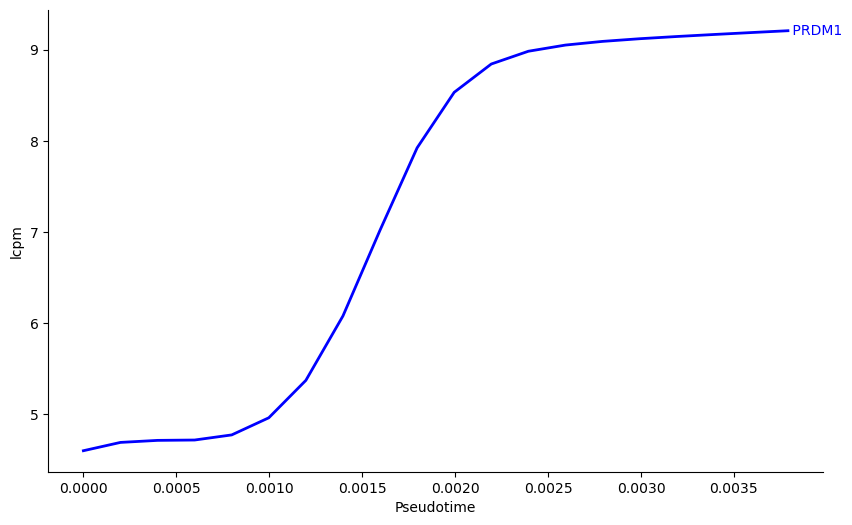

In [10]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['PRDM1']
colors = ['blue']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in lf_lcpm_curvature_gc.index:
        line = plt.plot(dtime_pb, lf_lcpm_dcurve_pb.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_pb.iloc[-1], lf_lcpm_dcurve_pb.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('lcpm')
plt.show()

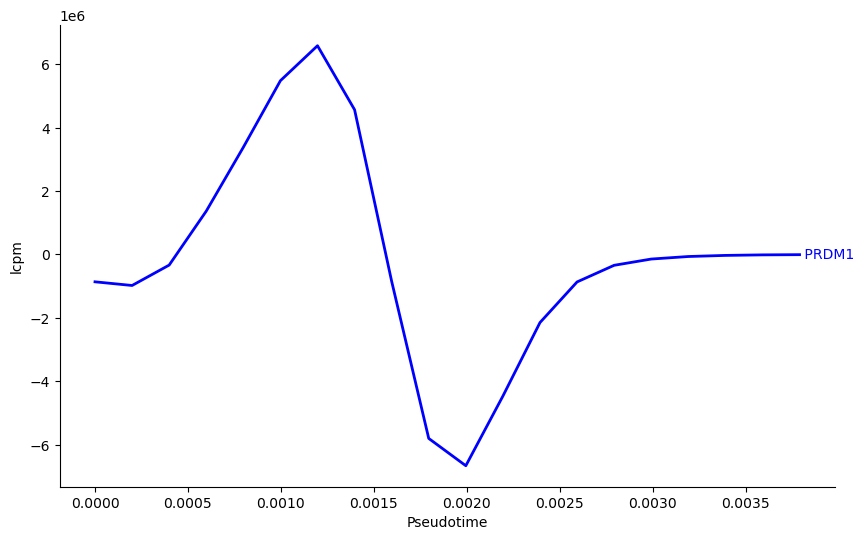

In [11]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Highlight specific genes
genes_of_interest = ['PRDM1']
colors = ['blue']   # Define colors for each gene

for gene, color in zip(genes_of_interest, colors):
    if gene in lf_lcpm_curvature_gc.index:
        line = plt.plot(dtime_pb, lf_lcpm_curvature_pb.loc[gene], linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_pb.iloc[-1], lf_lcpm_curvature_pb.loc[gene].iloc[-1], f' {gene}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('lcpm')
plt.show()

# Regulation dynamics of the LF genes


#### Get subnetworks for the dynamic genes in one lineage

In [12]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,20,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [13]:
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 20)

In [14]:
# compute the weighted network
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 20)

In [15]:
# # save the dnet and dnetbin as npy 
np.save(os.path.join(output_folder, 'dnet_pb_20pts.npy'), dnet)
np.save(os.path.join(output_folder, 'dnetbin_pb_20pts.npy'), dnetbin)

In [10]:
#load the dnet and dnetbin
dnet = np.load(os.path.join(output_folder, 'dnet_pb_20pts.npy'))
dnetbin = np.load(os.path.join(output_folder, 'dnetbin_pb_20pts.npy'))

In [11]:
# get indices of the dynamic_pb_genes
lf_genes_indices = get_gene_indices(dictys_dynamic_object, lf_genes)
display(len(lf_genes_indices))  

57

In [12]:
subnetworks_bin = dnetbin[np.ix_(range(dnetbin.shape[0]), lf_genes_indices, range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(551, 57, 20)

#### Filter TFs from the entire list (551)

In [13]:
# Calculate sparsity for each TF (across all genes and timepoints)
TF_density = (subnetworks_bin != 0).mean(axis=(1, 2))
# Keep TFs that are non-zero more than x% of the time
TFs_to_keep = TF_density > 0.01
TFs_to_keep_indices = np.where(TFs_to_keep)[0]

# Get TF names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
TFs_to_keep_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in TFs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in TFs_to_keep_gene_indices]
print(len(kept_tf_names))

219


In [14]:
# Get the subnetworks for the kept TFs
filtered_subnetworks = dnet[np.ix_(TFs_to_keep_indices, lf_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(219, 57, 20)

#### Get beta curves for a lineage


In [15]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in kept_tf_names for target in lf_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
lf_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(lf_beta_dcurve.head())

time_0    time_1        time_2        time_3        time_4  \
TF  Target                                                                 
AHR TXNDC5  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
    SEL1L3  0.000011  0.000003  8.759955e-07  2.038087e-07  4.277742e-08   
    FNDC3B  0.000019  0.000010  4.670108e-06  1.915626e-06  7.089742e-07   
    MZB1    0.009809  0.009032  7.059664e-03  4.814926e-03  2.935392e-03   
    PDE4D   0.001727  0.000920  4.281252e-04  1.766105e-04  6.573529e-05   

                  time_5        time_6        time_7        time_8  \
TF  Target                                                           
AHR TXNDC5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    SEL1L3  8.173113e-09  1.406945e-09  2.100272e-10  2.553644e-11   
    FNDC3B  2.388881e-07  7.253325e-08  1.910066e-08  4.097367e-09   
    MZB1    1.620194e-03  8.031369e-04  3.445866e-04  1.202863e-04   
    PDE4D   2.227537e-05  6.801890e-06  1.801371e-06  3.886169e-07   

                  time_9       time_10       time_11       time_12  \
TF  Target                                                           
AHR TXNDC5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    SEL1L3  2.391578e-12  1.706421e-13  9.540615e-15  4.331729e-16   
    FNDC3B  6.771076e-10  8.525971e-11  8.413423e-12  6.742941e-13   
    MZB1    3.232248e-05  6.614991e-06  1.060664e-06  1.381030e-07   
    PDE4D   6.458574e-08  8.178714e-09  8.116635e-10  6.542065e-11   

                 time_13       time_14       time_15       time_16  \
TF  Target                                                           
AHR TXNDC5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    SEL1L3  1.646959e-17  5.388661e-19  1.554810e-20  4.037817e-22   
    FNDC3B  4.525998e-14  2.614608e-15  1.332129e-16  6.109520e-18   
    MZB1    1.505829e-08  1.413032e-09  1.169402e-10  8.711471e-12   
    PDE4D   4.416131e-12  2.565643e-13  1.314614e-14  6.063469e-16   

                 time_17       time_18       time_19  
TF  Target                                            
AHR TXNDC5  0.000000e+00  0.000000e+00  0.000000e+00  
    SEL1L3  9.590537e-24  2.109421e-25  4.340020e-27  
    FNDC3B  2.562960e-19  9.957418e-21  3.619133e-22  
    MZB1    5.935973e-13  3.745965e-14  2.211523e-15  
    PDE4D   2.558104e-17  9.995054e-19  3.653467e-20

In [16]:
# save the lf_beta_dcurve as a pickle
lf_beta_dcurve.to_pickle(os.path.join(output_folder, 'lf_beta_dcurve_pb.pkl'))
# load the lf_beta_dcurve from pickle
#lf_beta_dcurve = pd.read_pickle(os.path.join(output_folder, 'lf_beta_dcurve_pb.pkl'))


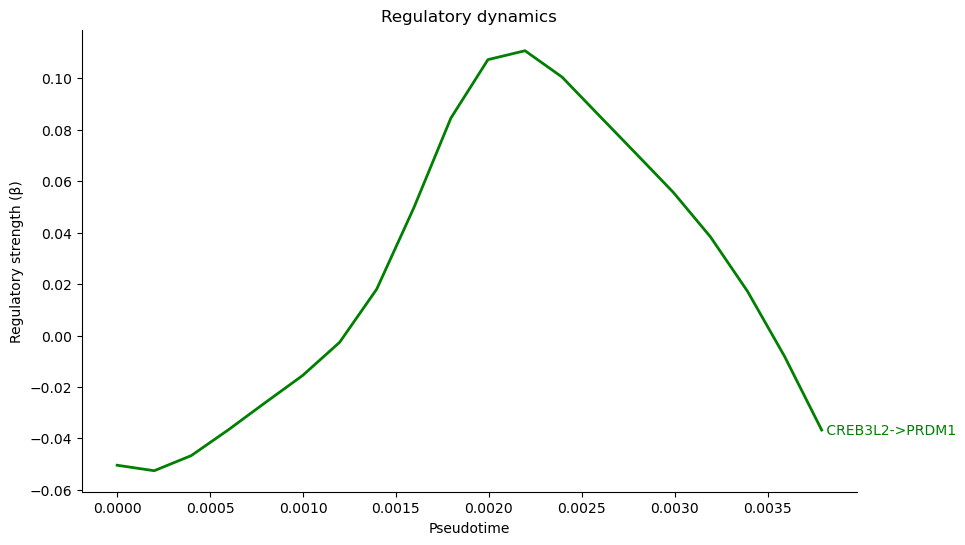

In [17]:
# Plot beta trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Specify TF-target pairs of interest
regulations_of_interest = [('CREB3L2', 'PRDM1')]
colors = ['green']   # Define colors for each regulation

for (tf, target), color in zip(regulations_of_interest, colors):
    # Create multi-index key for the regulation
    idx = pd.MultiIndex.from_tuples([(tf, target)])
    if (tf, target) in lf_beta_dcurve.index:
        line = plt.plot(dtime_pb, lf_beta_dcurve.loc[(tf, target)], 
                       linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime_pb.iloc[-1], 
                lf_beta_dcurve.loc[(tf, target)].iloc[-1], 
                f' {tf}->{target}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Regulatory strength (β)')
plt.title('Regulatory dynamics')
plt.show()

#### Get forces for the LF genes

In [18]:
# get the tf_lcpms for the lineage
kept_tfs_lcpm_dcurve = lcpm_dcurve_pb.loc[kept_tf_names]
print(len(kept_tfs_lcpm_dcurve))

219


In [19]:
lf_forces_dcurve = calculate_force_curves(lf_beta_dcurve, kept_tfs_lcpm_dcurve)
display(lf_forces_dcurve.head())
display(lf_forces_dcurve.shape)

time_0    time_1    time_2    time_3    time_4    time_5  \
TF  Target                                                               
AHR TXNDC5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SEL1L3  0.016620  0.009866  0.005501  0.002906  0.001468  0.000714   
    FNDC3B  0.021012  0.015954  0.011379  0.007689  0.004966  0.003079   
    MZB1    0.316279  0.305320  0.273487  0.230450  0.184845  0.141978   
    PDE4D   0.148771  0.113236  0.080967  0.054842  0.035504  0.022064   

              time_6    time_7    time_8    time_9   time_10   time_11  \
TF  Target                                                               
AHR TXNDC5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SEL1L3  0.000339  0.000169  0.000113  0.000103  0.000101  0.000100   
    FNDC3B  0.001824  0.001016  0.000520  0.000248  0.000132  0.000104   
    MZB1    0.104020  0.071486  0.044859  0.025125  0.012516  0.005610   
    PDE4D   0.013098  0.007300  0.003717  0.001691  0.000687  0.000262   

             time_12   time_13   time_14   time_15   time_16   time_17  \
TF  Target                                                               
AHR TXNDC5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    SEL1L3  0.000099  0.000098  0.000097  0.000097  0.000096  0.000095   
    FNDC3B  0.000100  0.000098  0.000097  0.000097  0.000096  0.000095   
    MZB1    0.002296  0.000871  0.000317  0.000135  0.000099  0.000095   
    PDE4D   0.000124  0.000100  0.000098  0.000097  0.000096  0.000095   

             time_18   time_19  
TF  Target                      
AHR TXNDC5  0.000000  0.000000  
    SEL1L3  0.000094  0.000094  
    FNDC3B  0.000094  0.000094  
    MZB1    0.000094  0.000094  
    PDE4D   0.000094  0.000094

(12483, 20)

In [19]:
# save the lf_forces_dcurve_pb as a pickle
lf_forces_dcurve.to_pickle(os.path.join(output_folder, 'lf_forces_dcurve_pb.pkl'))
# load lf_forces_dcurve_pb from pickle
#lf_forces_dcurve_pb = pd.read_pickle(os.path.join(output_folder, 'lf_forces_dcurve_pb.pkl'))


In [20]:
lf_force_curves_sorted_by_target = lf_forces_dcurve.sort_index(level=1)
display(lf_force_curves_sorted_by_target.head())
display(lf_force_curves_sorted_by_target.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,time_10,time_11,time_12,time_13,time_14,time_15,time_16,time_17,time_18,time_19
TF,Target,,,,,,,,,,,,,,,,,,,,
AHR,AFF3,0.223445,0.24313,0.248487,0.240597,0.222978,0.200392,0.182778,0.198039,0.275498,0.399436,0.53498,0.653704,0.737286,0.77849,0.781255,0.757388,0.721732,0.688385,0.667968,0.665503
ARID3B,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARID5A,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARNT,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARNTL,AFF3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


(12483, 20)

# Picking TFs for local enrichment analysis

In [21]:
def plot_tf_force_histogram_per_target(force_df, target, timepoint_idx=0, n_bins=20, 
                                      fig_size=(10, 6), show_tf_names=True, max_annotations=3,
                                      force_threshold=0.1, use_abs=False):
    """
    Plot histogram of TF force values for a specific target at a specific timepoint
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get column name if timepoint_idx is an integer
    if isinstance(timepoint_idx, int):
        timepoint_name = force_df.columns[timepoint_idx]
    else:
        timepoint_name = timepoint_idx
    
    # Get force values for this target
    target_mask = force_df.index.get_level_values(1) == target
    target_data = force_df[target_mask]
    raw_forces = target_data[timepoint_name].values
    
    # Use absolute values for histogram if requested
    if use_abs:
        forces = np.abs(raw_forces)
    else:
        forces = raw_forces
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Generate histogram
    counts, bins, patches = ax.hist(forces, bins=n_bins, alpha=0.7, color='skyblue', 
                                   edgecolor='black')
    
    # Add bin annotations (count of TFs in each bin)
    for i in range(len(patches)):
        # Get x position of the bin
        x = (bins[i] + bins[i+1]) / 2
        # Get y position (count)
        y = counts[i]
        # Add text if count > 0
        if y > 0:
            ax.text(x, y + (max(counts) * 0.02) if max(counts) > 0 else 0.5, 
                   f'{int(y)}', ha='center', va='bottom', fontsize=8)
    
    # Get TF names for annotations
    tfs = target_data.index.get_level_values(0).values
    # Annotate strong TFs if requested
    if show_tf_names:
        # Create lists to store strong positive and negative TFs
        strong_pos_tfs = []
        strong_neg_tfs = []
        
        # Find TFs with force above threshold
        for tf, force in zip(tfs, raw_forces):  # Use raw forces for directional information
            abs_force = abs(force)
            if abs_force > force_threshold:
                if force > 0:
                    strong_pos_tfs.append((tf, force))
                else:
                    strong_neg_tfs.append((tf, force))
        
        # Sort by absolute force
        strong_pos_tfs.sort(key=lambda x: x[1], reverse=True)
        strong_neg_tfs.sort(key=lambda x: abs(x[1]), reverse=True)
        
        # Limit to max_annotations for each category
        strong_pos_tfs = strong_pos_tfs[:max_annotations]
        strong_neg_tfs = strong_neg_tfs[:max_annotations]
        
        # Add text annotations within the plot area
        y_pos = 0.92  # Position relative to axes (0-1 range)
        if strong_pos_tfs:
            pos_text = "Top positive TFs: " + ", ".join([f"{tf} ({force:.2f})" for tf, force in strong_pos_tfs])
            ax.text(0.5, y_pos, pos_text, ha='center', va='top', 
                   fontsize=9, color='green', transform=ax.transAxes, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
            y_pos -= 0.07  # Move down for next annotation
        
        if strong_neg_tfs:
            neg_text = "Top negative TFs: " + ", ".join([f"{tf} ({force:.2f})" for tf, force in strong_neg_tfs])
            ax.text(0.5, y_pos, neg_text, ha='center', va='top', 
                   fontsize=9, color='red', transform=ax.transAxes, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
    
    # Set plot labels and title
    if use_abs:
        ax.set_xlabel('Absolute Force Value')
        ax.set_title(f'Distribution of Absolute TF Forces for {target} at Timepoint {timepoint_name}')
    else:
        ax.set_xlabel('Force Value')
        ax.set_title(f'Distribution of TF Forces for {target} at Timepoint {timepoint_name}')
    
    ax.set_ylabel('Count of TFs')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add grid
    ax.grid(axis='y', alpha=0.3)
    
    return fig, ax

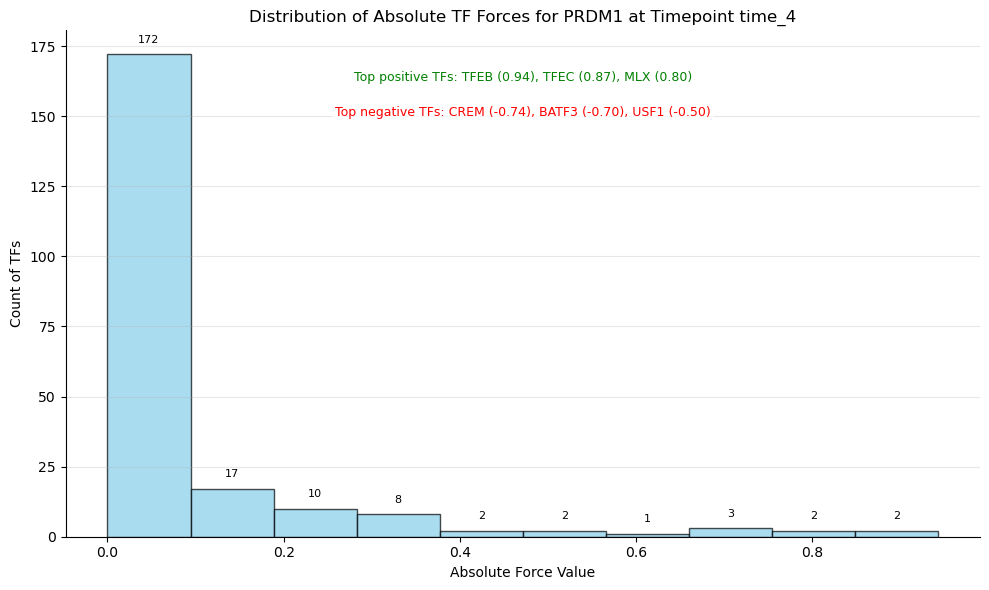

In [36]:
# Example usage:
# 1. For a single target with absolute force values
timepoint_idx = 4
target_of_interest = "PRDM1"  # Replace with your target of interest

fig, ax = plot_tf_force_histogram_per_target(
    force_df=lf_force_curves_sorted_by_target,
    target=target_of_interest,
    timepoint_idx=timepoint_idx,
    n_bins=10,
    show_tf_names=True,
    force_threshold=0.1,
    use_abs=True  # Use absolute force values
)
plt.tight_layout()
plt.show()


In [11]:
def find_max_force_per_target(force_df):
    """
    Find TFs exerting maximum absolute force per target at each timepoint
    Returns DataFrame with force trajectories ordered by time of maximum force
    """
    # Initialize dictionary to store results
    max_force_dict = {}
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    # Process each target
    for target in targets:
        # Get all TFs for this target using boolean indexing
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        # Store the max force TF indices for each timepoint
        max_force_indices = []
        for col in force_df.columns:
            # Find TF with max absolute force at this time point
            max_force_idx = target_data[col].abs().idxmax()
            max_force_indices.append(max_force_idx)
        # Get the force trajectories for these TFs
        max_force_trajectories = force_df.loc[max_force_indices]
        max_force_dict[target] = max_force_trajectories
    # Concatenate all target results
    result_df = pd.concat(max_force_dict.values())
    return result_df

def find_top_k_forces_per_target(force_df, k=5):
    """
    Find the top 5 TFs exerting maximum absolute force per target at each timepoint.
    Returns a DataFrame with force trajectories ordered by time of maximum force.
    """
    # Initialize dictionary to store results
    top_force_dict = {}
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Process each target
    for target in targets:
        # Get all TFs for this target using boolean indexing
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Store the top 5 force TF indices for each timepoint
        top_force_indices = []
        for col in force_df.columns:
            # Get indices of the top 5 TFs with max absolute force at this time point
            top_force_idx = target_data[col].abs().nlargest(k).index
            top_force_indices.extend(top_force_idx)
        
        # Get the force trajectories for these TFs
        top_force_trajectories = force_df.loc[top_force_indices]
        top_force_dict[target] = top_force_trajectories
    
    # Concatenate all target results
    result_df = pd.concat(top_force_dict.values())
    return result_df

def find_top_k_forces_per_target_gpu(force_df, k=5):
    try:
        import cudf
        import cupy as cp
        from numba import cuda
        gpu_available = True
    except ImportError:
        print("GPU libraries not available. Install RAPIDS (cudf, cupy) for GPU acceleration.")
        print("Falling back to CPU implementation.")
        return find_top_k_forces_per_target(force_df, k)
    
    # Initialize dictionary to store results
    top_force_dict = {}
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Process targets in parallel batches
    batch_size = min(100, len(targets))  # Adjust batch size based on GPU memory
    for batch_start in range(0, len(targets), batch_size):
        batch_targets = targets[batch_start:batch_start + batch_size]
        
        # Process each target in the batch
        for target in batch_targets:
            # Get all TFs for this target using boolean indexing
            target_mask = force_df.index.get_level_values(1) == target
            target_data = force_df[target_mask]
            
            # Convert to GPU DataFrame
            gpu_data = cudf.from_pandas(target_data)
            
            # Store the top k force TF indices for each timepoint
            top_force_indices = []
            
            # Process columns in batches to avoid GPU memory issues
            col_batch_size = 20  # Adjust based on available GPU memory
            for col_start in range(0, len(target_data.columns), col_batch_size):
                col_batch = target_data.columns[col_start:col_start + col_batch_size]
                
                for col in col_batch:
                    # Find top k TFs with max absolute force at this timepoint
                    abs_series = gpu_data[col].abs()
                    top_k_indices = abs_series.nlargest(k).index.to_pandas()
                    top_force_indices.extend(top_k_indices)
            
            # Get the force trajectories for these TFs and move back to CPU
            top_force_trajectories = force_df.loc[top_force_indices]
            top_force_dict[target] = top_force_trajectories
            
            # Clear GPU memory
            del gpu_data
            cuda.current_context().memory_manager.deallocations.clear()
    
    # Concatenate all target results
    result_df = pd.concat(top_force_dict.values())
    return result_df

In [37]:
def find_top_percentile_tfs_across_time(force_df, percentile=95, time_window=None, use_abs=True):
    """
    Find TFs that are in the top percentile of force values across consecutive timepoints.
    """
    import numpy as np
    from collections import defaultdict
    
    # Get the timepoints to analyze
    if time_window is None:
        timepoints = force_df.columns
    else:
        start, end = time_window
        timepoints = force_df.columns[start:end]
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Dictionary to store TF persistence per target
    target_tf_persistence = {}
    
    # Process each target separately
    for target in targets:
        # Dictionary to track consecutive appearances for this target
        tf_consecutive_counts = defaultdict(int)
        
        # Previous timepoint's top TFs
        prev_top_tfs = set()
        
        # Get all TFs for this target
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Skip targets with no data
        if len(target_data) == 0:
            continue
            
        # Iterate through timepoints
        for i, timepoint in enumerate(timepoints):
            # Get force values for this timepoint
            forces = target_data[timepoint].values
            
            # Use absolute values if requested
            if use_abs:
                forces = np.abs(forces)
            
            # Calculate the percentile threshold
            threshold = np.percentile(forces, percentile)
            
            # Find TFs above the threshold
            tf_indices = np.where(forces >= threshold)[0]
            
            # Get TF names
            current_top_tfs = set(target_data.index.get_level_values(0)[tf_indices])
            
            # For the first timepoint, just set previous TFs
            if i == 0:
                prev_top_tfs = current_top_tfs
                continue
            
            # Find TFs that appear in both current and previous timepoints
            consecutive_tfs = current_top_tfs.intersection(prev_top_tfs)
            
            # Increment counts for consecutive TFs
            for tf in consecutive_tfs:
                tf_consecutive_counts[tf] += 1
            
            # Update previous timepoint's TFs
            prev_top_tfs = current_top_tfs
        
        # Store results for this target
        target_tf_persistence[target] = dict(tf_consecutive_counts)
    
    return target_tf_persistence

def get_target_specific_regulators(force_df, percentile=95, time_window=None, 
                                use_abs=True, min_consecutive=1, target_list=None):
    """
    Find TFs that consistently appear in the top percentile of force values for specific targets.
        
    Returns:
    --------
    dict : Dictionary with target genes as keys and dictionaries of {TF -> persistence count} as values
    """
    # Get TF persistence data for all targets
    target_tf_persistence = find_top_percentile_tfs_across_time(
        force_df=force_df,
        percentile=percentile,
        time_window=time_window,
        use_abs=use_abs
    )
    
    # Filter by minimum consecutive appearances and targets of interest
    filtered_persistence = {}
    
    for target, tf_dict in target_tf_persistence.items():
        # Skip if not in target list (when specified)
        if target_list is not None and target not in target_list:
            continue
            
        # Filter TFs by minimum consecutive appearances
        filtered_tfs = {tf: count for tf, count in tf_dict.items() if count >= min_consecutive}
        
        # Only add if there are any TFs left after filtering
        if filtered_tfs:
            filtered_persistence[target] = filtered_tfs
    
    return filtered_persistence

def visualize_top_regulators_per_target(target_regulators, top_n=10, figsize=(15, 10), n_cols=2):
    """
    Visualize top regulating TFs for multiple targets.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math
    
    # Get number of targets
    n_targets = len(target_regulators)
    
    # Calculate number of rows needed
    n_rows = math.ceil(n_targets / n_cols)
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Create bar chart for each target
    for i, (target, tf_persistence) in enumerate(target_regulators.items()):
        if i < len(axes):
            ax = axes[i]
            
            # Sort TFs by persistence count
            sorted_tfs = sorted(tf_persistence.items(), key=lambda x: x[1], reverse=True)[:top_n]
            
            if not sorted_tfs:
                ax.text(0.5, 0.5, f"No persistent TFs for {target}", 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
                continue
                
            # Get TF names and counts
            tf_names = [tf for tf, _ in sorted_tfs]
            tf_counts = [count for _, count in sorted_tfs]
            
            # Plot horizontal bar chart for better readability of TF names
            bars = ax.barh(tf_names, tf_counts, color='skyblue', edgecolor='black')
            
            # Add count labels
            for bar, count in zip(bars, tf_counts):
                ax.text(count + 0.1, bar.get_y() + bar.get_height()/2, 
                       str(count), va='center', fontsize=9)
            
            # Set title and labels
            ax.set_title(f"{target}")
            ax.set_xlabel("Consecutive Appearances")
            
            # Remove top and right spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
    # Hide unused subplots
    for i in range(n_targets, len(axes)):
        axes[i].axis('off')
    
    # Add overall title
    plt.suptitle("Persistent Top Regulating TFs by Target", fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

In [75]:
# 1. Find target-specific regulators
percentile = 90
time_window = 15,19 # Use all timepoints
use_abs = True  # Use absolute force values
min_consecutive = 2  # TF must appear in consecutive timepoints at least this many times

# Choose specific targets or use None for all targets
targets_of_interest = None

target_regulators = get_target_specific_regulators(
    force_df=lf_force_curves_sorted_by_target,
    percentile=percentile,
    time_window=time_window,
    use_abs=use_abs,
    min_consecutive=min_consecutive,
    target_list=targets_of_interest
)

In [76]:
display(target_regulators)

{'AFF3': {np.str_('SOX4'): 3,
  np.str_('TCF12'): 3,
  np.str_('CTCF'): 3,
  np.str_('REL'): 3,
  np.str_('ZNF37A'): 3,
  np.str_('NFATC3'): 3,
  np.str_('NRF1'): 3,
  np.str_('GABPA'): 3,
  np.str_('MEF2C'): 3,
  np.str_('MZF1'): 3,
  np.str_('AHR'): 3,
  np.str_('ZNF736'): 2,
  np.str_('ZNF846'): 3,
  np.str_('ELF1'): 2,
  np.str_('IKZF1'): 3,
  np.str_('RUNX3'): 3,
  np.str_('ELK3'): 3,
  np.str_('TCFL5'): 3,
  np.str_('ZNF566'): 2,
  np.str_('ZNF2'): 2},
 'ANKRD28': {np.str_('TCF12'): 3,
  np.str_('CTCF'): 3,
  np.str_('KLF13'): 2,
  np.str_('NRF1'): 3,
  np.str_('NFYB'): 3,
  np.str_('ZNF519'): 3,
  np.str_('ZNF571'): 3,
  np.str_('ZNF22'): 3,
  np.str_('MEF2C'): 2,
  np.str_('NFYC'): 2,
  np.str_('MZF1'): 3,
  np.str_('ZNF736'): 3,
  np.str_('TCF4'): 3,
  np.str_('MAZ'): 3,
  np.str_('IKZF3'): 3,
  np.str_('ZNF730'): 3,
  np.str_('RUNX1'): 3,
  np.str_('MECP2'): 3,
  np.str_('RUNX3'): 3,
  np.str_('TCFL5'): 2,
  np.str_('LIN54'): 2},
 'ARFGAP3': {np.str_('ZNF770'): 3,
  np.str_('

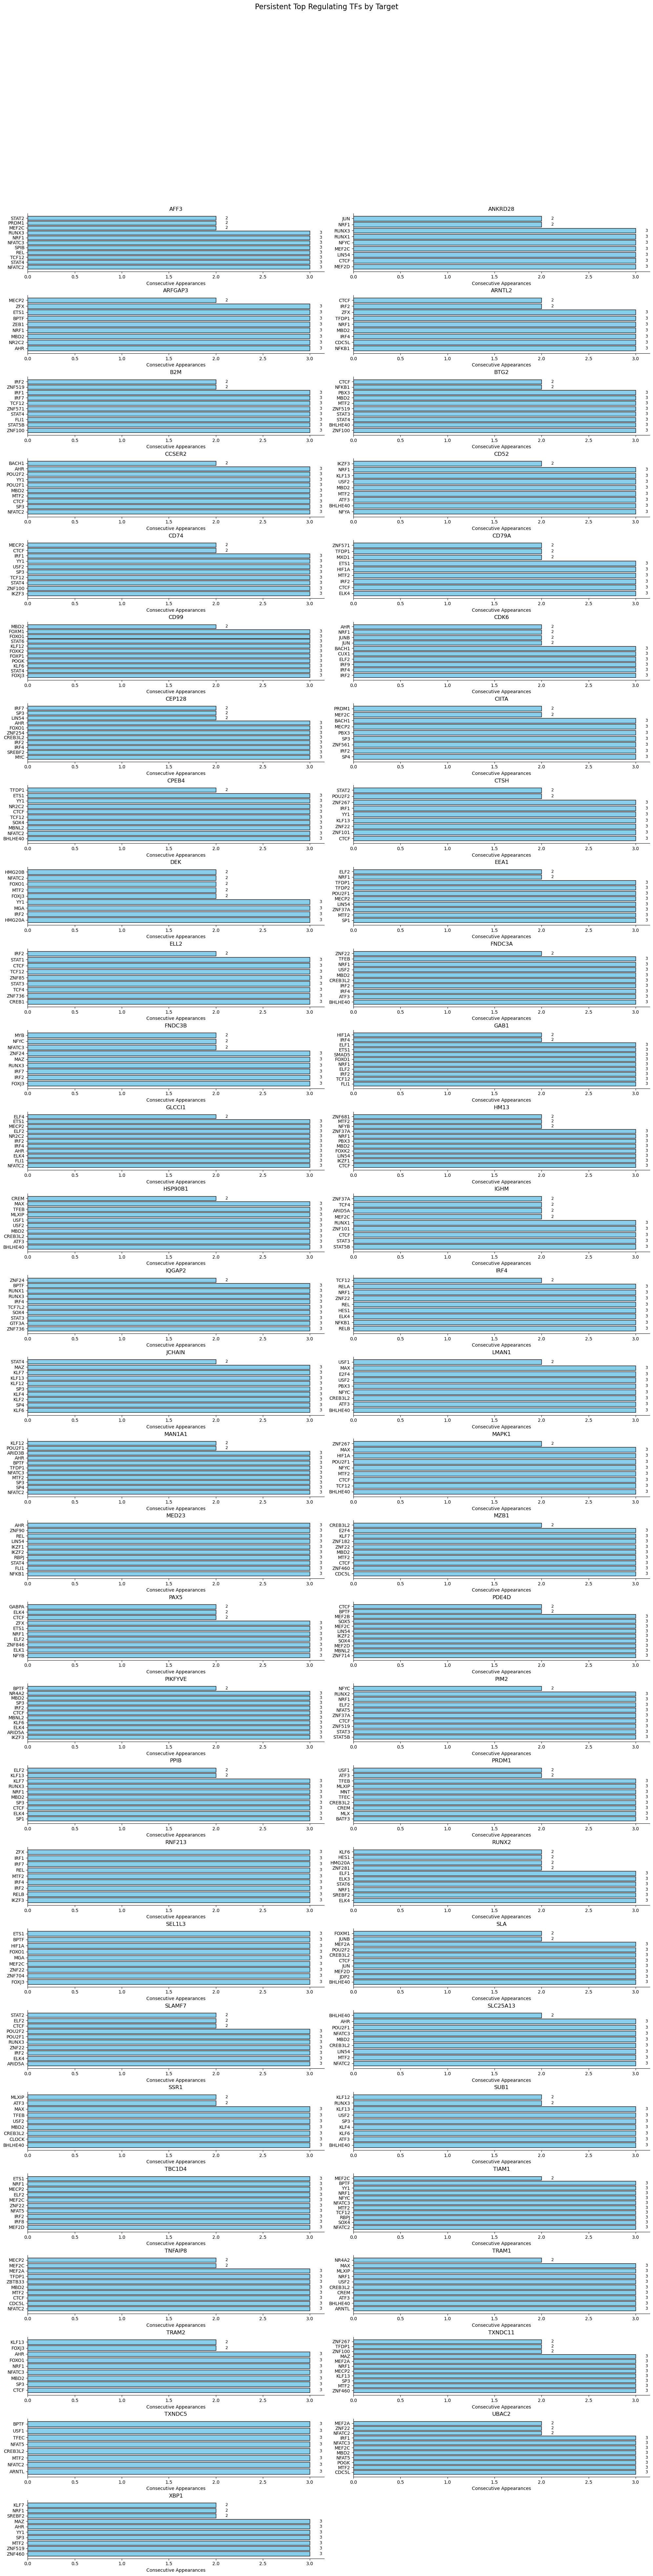

In [60]:
# 2. Visualize target-specific regulators
fig = visualize_top_regulators_per_target(
    target_regulators=target_regulators,
    top_n=40,
    figsize=(20, 80),
    n_cols=2
)
plt.show()

In [29]:
# Get max force
max_force_trajectories = find_top_k_forces_per_target(lf_force_curves_sorted_by_target, k=5)

In [ ]:
display(max_force_trajectories.head())
display(max_force_trajectories.shape)

In [ ]:
lf_gene_regulations = get_unique_regs_by_target(max_force_trajectories)
# Get all unique TFs
all_tfs = set(tf for regs in lf_gene_regulations.values() 
                for tf, _ in regs)

# Create dictionary of TF -> list of targets
tf_to_targets = {}
for tf in all_tfs:
    # Find all targets regulated by this TF
    targets = [target for target, regs in lf_gene_regulations.items() 
                if any(reg[0] == tf for reg in regs)]
    tf_to_targets[tf] = targets
print(tf_to_targets)
print(len(all_tfs))
print(sum(len(values) for values in tf_to_targets.values()))

In [45]:
# # save tf_to_targets as a pickle
# import pickle
# with open(os.path.join(output_folder, 'top_5_TFs_per_target_pb_from_1_to_2.pkl'), 'wb') as f:
#     pickle.dump(tf_to_targets, f)


In [ ]:
fig, ax, force_values = plot_force_heatmap(
    force_df=lf_forces_dcurve,
    dtime=dtime,
    #regulations=lf_gene_regulations['HLA-DPA1'],
    tf_to_targets_dict={'PRDM1': tf_to_targets['PRDM1']},
    figsize=(12, 6),
    cmap='RdYlGn'
)

## Get the local enrichment  for the picked TFs

In [32]:
# load the filtered_tfs from top 5 TFs per target
import pickle
tf_to_targets = pickle.load(open(os.path.join(output_folder, 'top_5_TFs_per_target_pb.pkl'), 'rb'))

In [33]:
# get the total down-stream targets of the filtered TFs
filtered_tfs = list(tf_to_targets.keys())
filtered_tfs_indices, _, _ = get_tf_indices(dictys_dynamic_object, filtered_tfs)
print(len(filtered_tfs_indices))

181


In [34]:
# Get the subnetworks for the kept TFs
filtered_subnetworks_max_force_tfs = dnet[np.ix_(filtered_tfs_indices, range(dnet.shape[1]), range(dnet.shape[2]))]
display(filtered_subnetworks_max_force_tfs.shape)

(181, 11907, 100)

In [35]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in filtered_tfs for target in dictys_dynamic_object.ndict.keys()]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks_max_force_tfs.shape
reshaped_data = filtered_subnetworks_max_force_tfs.reshape(-1, n_times)

# Create DataFrame with multi-index
max_force_tfs_beta_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(max_force_tfs_beta_dcurve.head())

time_0  time_1  time_2  time_3  time_4  time_5  time_6  time_7  \
TF   Target                                                                     
BATF A1BG         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     A1BG-AS1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     AAAS         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     AACS         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
     AAGAB        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

               time_8  time_9  ...  time_90  time_91  time_92  time_93  \
TF   Target                    ...                                       
BATF A1BG         0.0     0.0  ...      0.0      0.0      0.0      0.0   
     A1BG-AS1     0.0     0.0  ...      0.0      0.0      0.0      0.0   
     AAAS         0.0     0.0  ...      0.0      0.0      0.0      0.0   
     AACS         0.0     0.0  ...      0.0      0.0      0.0      0.0   
     AAGAB        0.0     0.0  ...      0.0      0.0      0.0      0.0   

               time_94  time_95  time_96  time_97  time_98  time_99  
TF   Target                                                          
BATF A1BG          0.0      0.0      0.0      0.0      0.0      0.0  
     A1BG-AS1      0.0      0.0      0.0      0.0      0.0      0.0  
     AAAS          0.0      0.0      0.0      0.0      0.0      0.0  
     AACS          0.0      0.0      0.0      0.0      0.0      0.0  
     AAGAB         0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 100 columns]

In [36]:
# get the tf_lcpms for the lineage
filtered_tfs_lcpm_dcurve = lcpm_dcurve_pb.loc[filtered_tfs]
print(len(filtered_tfs_lcpm_dcurve))

181


In [37]:
filtered_tfs_all_forces_dcurve = calculate_force_curves(max_force_tfs_beta_dcurve, filtered_tfs_lcpm_dcurve)
filtered_tfs_all_forces_dcurve = filtered_tfs_all_forces_dcurve.sort_index(level=1)
display(filtered_tfs_all_forces_dcurve.head())
display(filtered_tfs_all_forces_dcurve.shape)

,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
TF,Target,,,,,,,,,,,,,,,,,,,,,
AHR,A1BG,0.325194,0.314337,0.301522,0.286602,0.269356,0.249442,0.226288,0.198849,0.164903,0.117998,...,0.773687,0.774077,0.774641,0.775324,0.776076,0.776855,0.777623,0.778347,0.778999,0.779555
ARID3B,A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARID5A,A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARNTL,A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ATF3,A1BG,-0.132348,-0.132730,-0.132753,-0.132422,-0.131744,-0.130731,-0.129397,-0.127760,-0.125838,-0.123654,...,-0.000078,-0.000078,-0.000077,-0.000077,-0.000077,-0.000077,-0.000077,-0.000077,-0.000076,-0.000076


(2155167, 100)

In [38]:
# Optimized version of the parallel processing function
def process_target_chunk_for_parallel(targets_chunk_args):
    targets_chunk, force_df, k = targets_chunk_args
    results = []
    
    # Convert to numpy for faster operations (one-time conversion)
    # Create index mappings for fast lookups
    all_tfs = force_df.index.get_level_values(0).unique()
    all_targets = force_df.index.get_level_values(1).unique()
    tf_to_idx = {tf: i for i, tf in enumerate(all_tfs)}
    target_to_idx = {target: i for i, target in enumerate(all_targets)}
    
    # Pre-compute masks for each target to avoid repeated filtering
    for target in targets_chunk:
        # Filter for this target (more efficient than refiltering repeatedly)
        target_mask = force_df.index.get_level_values(1) == target
        target_data = force_df[target_mask]
        
        # Find all unique TFs for this target
        tfs_for_target = target_data.index.get_level_values(0).unique()
        
        # Pre-compute TF indices for faster lookups in the loop
        top_force_indices = set()
        
        # For each column, find top k forces
        for col in force_df.columns:
            # More efficient abs and sorting using numpy operations
            abs_vals = np.abs(target_data[col].values)
            # Use numpy argpartition for faster partial sorting (O(n) vs O(n log k))
            if len(abs_vals) > k:
                top_k_indices = np.argpartition(abs_vals, -k)[-k:]
            else:
                top_k_indices = range(len(abs_vals))
                
            # Get the actual indices from the DataFrame
            for idx in top_k_indices:
                top_force_indices.add(target_data.index[idx])
        
        # Extract forces for top indices
        if top_force_indices:
            top_forces = force_df.loc[list(top_force_indices)]
            results.append(top_forces)
    
    # Combine results for this chunk
    if results:
        return pd.concat(results)
    return pd.DataFrame()

def find_top_k_forces_per_target_optimized(force_df, k=5, n_jobs=None, chunk_size=100):
    import multiprocessing as mp
    from tqdm import tqdm
    import numpy as np
    
    # Get unique targets
    targets = force_df.index.get_level_values(1).unique()
    
    # Set number of processes
    if n_jobs is None:
        n_jobs = mp.cpu_count()
    
    # Split targets into chunks for batch processing (reduces overhead)
    target_chunks = [targets[i:i + chunk_size] for i in range(0, len(targets), chunk_size)]
    print(f"Processing {len(targets)} targets in {len(target_chunks)} chunks using {n_jobs} CPU cores...")
    
    # Create arguments list with chunks
    args_list = [(chunk, force_df, k) for chunk in target_chunks]
    
    # Create a process pool with maxtasksperchild to prevent memory leaks
    with mp.Pool(processes=n_jobs, maxtasksperchild=10) as pool:
        # Process targets in parallel with progress bar
        results = list(tqdm(
            pool.imap(process_target_chunk_for_parallel, args_list),
            total=len(target_chunks),
            desc="Finding top TF regulators"
        ))
    
    # Filter out empty results and concatenate
    non_empty_results = [r for r in results if not r.empty]
    if non_empty_results:
        result_df = pd.concat(non_empty_results)
        print(f"Completed processing. Found {len(result_df)} TF-target regulations.")
        return result_df
    else:
        print("No regulations found.")
        return pd.DataFrame()

In [39]:
max_force_trajectories_filtered_tfs = find_top_k_forces_per_target_optimized(
    filtered_tfs_all_forces_dcurve, 
    k=5, 
    n_jobs=124,
    chunk_size=100
)
display(max_force_trajectories_filtered_tfs.head())
display(max_force_trajectories_filtered_tfs.shape)

Processing 11907 targets in 120 chunks using 124 CPU cores...


Finding top TF regulators: 100%|██████████| 120/120 [04:52<00:00,  2.44s/it]


Completed processing. Found 184643 TF-target regulations.


,,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8,time_9,...,time_90,time_91,time_92,time_93,time_94,time_95,time_96,time_97,time_98,time_99
TF,Target,,,,,,,,,,,,,,,,,,,,,
FLI1,A1BG,0.256200,0.258640,0.260622,0.262180,0.263353,0.264181,0.264707,0.264974,0.265025,0.264902,...,-0.991531,-0.993642,-0.995436,-0.996978,-0.998330,-0.999552,-1.000700,-1.001828,-1.002985,-1.004215
AHR,A1BG,0.325194,0.314337,0.301522,0.286602,0.269356,0.249442,0.226288,0.198849,0.164903,0.117998,...,0.773687,0.774077,0.774641,0.775324,0.776076,0.776855,0.777623,0.778347,0.778999,0.779555
NRF1,A1BG,-0.620895,-0.636112,-0.650122,-0.662922,-0.674515,-0.684908,-0.694117,-0.702161,-0.709066,-0.714861,...,0.752160,0.782474,0.808733,0.831629,0.851693,0.869344,0.884918,0.898686,0.910873,0.921664
ZNF100,A1BG,0.205830,0.204537,0.203495,0.202752,0.202347,0.202310,0.202656,0.203391,0.204506,0.205982,...,-0.275142,-0.336519,-0.383028,-0.420697,-0.452313,-0.479436,-0.503048,-0.523813,-0.542206,-0.558579
GABPA,A1BG,0.457850,0.463086,0.468078,0.472830,0.477344,0.481620,0.485653,0.489439,0.492968,0.496228,...,-0.914682,-0.922783,-0.930400,-0.937538,-0.944203,-0.950399,-0.956134,-0.961413,-0.966245,-0.970637


(184643, 100)

In [40]:
# save the max_force_trajectories_filtered_tfs as a pickle
max_force_trajectories_filtered_tfs.to_pickle(os.path.join(output_folder, 'max_forces_filtered_tfs_downstream_genes_pb.pkl'))
# load the max_force_trajectories_filtered_tfs from pickle
#max_force_trajectories_filtered_tfs = pd.read_pickle(os.path.join(output_folder, 'max_force_trajectories_filtered_tfs_gc.pkl'))


In [20]:
def process_target_chunk(targets_chunk, max_force_df):
    """
    Process a chunk of targets to get unique TF-target pairs
    """
    chunk_result = {}
    
    for target in targets_chunk:
        # Get rows for this target
        target_mask = max_force_df.index.get_level_values(1) == target
        target_data = max_force_df[target_mask]
        
        # Get unique TFs for this target
        unique_tfs = target_data.index.get_level_values(0).unique()
        
        # Create list of tuples
        tf_target_pairs = [(str(tf), str(target)) for tf in unique_tfs]
        
        # Store in dictionary
        chunk_result[target] = tf_target_pairs
        
    return chunk_result

def get_unique_regs_by_target_parallel(max_force_df, n_jobs=None, chunk_size=100):
    """
    Create dictionary of unique TF-target pairs for each target using parallel processing
    """
    import multiprocessing as mp
    from tqdm import tqdm
    
    # Get unique targets
    targets = max_force_df.index.get_level_values(1).unique()
    
    # Set number of processes
    if n_jobs is None:
        n_jobs = mp.cpu_count()
    
    # Split targets into chunks
    target_chunks = [targets[i:i + chunk_size] for i in range(0, len(targets), chunk_size)]
    print(f"Processing {len(targets)} targets in {len(target_chunks)} chunks using {n_jobs} CPU cores...")
    
    # Process chunks in parallel
    results = {}
    with mp.Pool(processes=n_jobs, maxtasksperchild=10) as pool:
        # Create a list of arguments for each chunk
        args = [(chunk, max_force_df) for chunk in target_chunks]
        
        # Apply the processing function to each chunk with progress tracking
        chunk_results = list(tqdm(
            pool.starmap(process_target_chunk, args),
            total=len(target_chunks),
            desc="Finding unique TF regulators"
        ))
        
        # Combine results from all chunks
        for chunk_result in chunk_results:
            results.update(chunk_result)
            
    print(f"Found unique TF regulators for {len(results)} targets")
    return results

In [41]:
filtered_tfs_regs = get_unique_regs_by_target_parallel(
    max_force_trajectories_filtered_tfs,
    n_jobs=124,  # Using the same number of jobs as in the previous function
    chunk_size=100
)

Processing 11907 targets in 120 chunks using 124 CPU cores...


Finding unique TF regulators: 100%|██████████| 120/120 [00:00<00:00, 270600.26it/s]


Found unique TF regulators for 11907 targets


In [42]:
# Get all unique TFs
all_tfs = set(tf for regs in filtered_tfs_regs.values() 
              for tf, _ in regs)

# Create dictionary of TF -> list of targets
tf_to_all_downstream_targets = {}
for tf in all_tfs:
    # Find all targets regulated by this TF
    targets = [target for target, regs in filtered_tfs_regs.items() 
               if any(reg[0] == tf for reg in regs)]
    tf_to_all_downstream_targets[tf] = targets
print(len(all_tfs))
print(sum(len(values) for values in tf_to_all_downstream_targets.values()))

181
184643


In [43]:
# save the tf_to_all_downstream_targets as a pickle
pickle.dump(tf_to_all_downstream_targets, open(os.path.join(output_folder, 'filtered_tfs_to_all_downstream_targets_pb.pkl'), 'wb'))
# load the tf_to_all_downstream_targets from pickle
#tf_to_all_downstream_targets = pickle.load(open(os.path.join(output_folder, 'tf_to_all_downstream_targets_gc.pkl'), 'rb'))


#### Get enrichment of filtered TFs related to the LF

In [44]:
# load the total downstream targets and LF targets of a lineage
tfs_total_downstream_targets = pickle.load(open(os.path.join(output_folder, 'filtered_tfs_to_all_downstream_targets_pb.pkl'), 'rb'))
tfs_lf_targets = pickle.load(open(os.path.join(output_folder, 'top_5_TFs_per_target_pb.pkl'), 'rb'))

In [25]:
def calculate_dynamic_tf_enrichment(tf_lf_targets_dict, tf_all_targets_dict, condition="GC", total_genes=None, total_lf_genes=None):
    """
    Calculate enrichment scores for transcription factors regulating latent factor genes
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import hypergeom
    import math
    
    # Get the total number of LF genes
    if total_lf_genes is None:
        # Calculate from dictionary if not provided
        all_lf_genes = set()
        for targets in tf_lf_targets_dict.values():
            all_lf_genes.update(targets)
        N = len(all_lf_genes)  # Total LF genes
    else:
        N = total_lf_genes  # Use provided value
    
    # If total_genes is not provided, estimate from the all_targets dictionary
    if total_genes is None:
        all_possible_targets = set()
        for targets in tf_all_targets_dict.values():
            all_possible_targets.update(targets)
        M = len(all_possible_targets)  # Total genes in the universe
    else:
        M = total_genes
    
    # Calculate enrichment for each TF
    results = []
    
    for tf in tf_lf_targets_dict.keys():
        if tf in tf_all_targets_dict:
            # Get unique targets for this TF
            lf_targets = set(tf_lf_targets_dict[tf])
            all_targets = set(tf_all_targets_dict[tf])
            
            # Calculate parameters for hypergeometric test
            n = len(all_targets)  # Number of total downstream targets
            X = len(lf_targets)   # Number of LF targets
            
            # Skip if there are no targets or all targets
            if n == 0 or n == M:
                continue
                
            # Calculate enrichment
            try:
                p_value = 1 - hypergeom.cdf(X-1, M, n, N)
                score = math.log2((X/n)/(N/M)) if X > 0 else float('-inf')
                
                # Format the results
                lf_genes = ", ".join(sorted(lf_targets))
                downstream_genes = ", ".join(sorted(all_targets))
                
                results.append({
                    'TF': f"({tf},)",
                    'Condition': f"({condition},)",
                    'Score': score,
                    'p_value': p_value,
                    'lf_targets': lf_genes,
                    'dwnstrm': downstream_genes
                })
            except Exception as e:
                print(f"Error calculating enrichment for {tf}: {e}")
                print(f"M={M}, n={n}, N={N}, X={X}")
    # Create DataFrame
    enrichment_df = pd.DataFrame(results)
    # Sort by p-value (ascending) and Score (descending)
    if not enrichment_df.empty:
        enrichment_df = enrichment_df.sort_values(by=['p_value', 'Score'], 
                                                 ascending=[True, False])
    return enrichment_df


In [45]:
enrichment_tf_gc = calculate_dynamic_tf_enrichment(
    tfs_lf_targets,                  # Dictionary with TFs -> LF targets
    tfs_total_downstream_targets,    # Dictionary with TFs -> all downstream targets
    condition="PB",
    total_genes=len(dictys_dynamic_object.ndict),  # Total number of genes in the analysis
    total_lf_genes=len(lf_genes)     # Total number of LF genes
)

# Save to CSV
enrichment_tf_gc.to_csv(os.path.join(output_folder, 'LF_enriched_dynamic_TFs_PB.csv'), index=False)

In [37]:
# load the enrichment_tfs from csv
enrichment_tf_gc = pd.read_csv(os.path.join(output_folder, 'LF_enriched_dynamic_TFs_GC.csv'))
enrichment_tf_pb = pd.read_csv(os.path.join(output_folder, 'LF_enriched_dynamic_TFs_PB.csv'))

In [45]:
p_value_cutoff = 0.05
significant_tfs_gc = enrichment_tf_gc[enrichment_tf_gc['p_value'] < p_value_cutoff]
significant_tfs_pb = enrichment_tf_pb[enrichment_tf_pb['p_value'] < p_value_cutoff]
print(len(significant_tfs_gc))
print(len(significant_tfs_pb))

18
24


In [54]:
common_tfs = set(significant_tfs_gc['TF']) & set(significant_tfs_pb['TF'])
print(len(common_tfs))
# make data by querying the common_tfs from the enrichment_tf_gc and enrichment_tf_pb
# Create a DataFrame with common TFs and their targets from both conditions
common_tf_data = []
for tf in common_tfs:
    # Get data for this TF in GC
    gc_row = significant_tfs_gc[significant_tfs_gc['TF'] == tf].iloc[0]
    
    # Get data for this TF in PB
    pb_row = significant_tfs_pb[significant_tfs_pb['TF'] == tf].iloc[0]
    
    # Convert target strings to sets for comparison
    gc_targets = set(target.strip() for target in gc_row['lf_targets'].split(','))
    pb_targets = set(target.strip() for target in pb_row['lf_targets'].split(','))
    
    # Find common targets
    common_targets = gc_targets.intersection(pb_targets)
    
    common_tf_data.append({
        'TF': tf,
        'GC_Score': gc_row['Score'],
        'PB_Score': pb_row['Score'],
        'GC_pvalue': gc_row['p_value'],
        'PB_pvalue': pb_row['p_value'],
        'GC_lf_targets': gc_row['lf_targets'],
        'PB_lf_targets': pb_row['lf_targets'],
        'common_targets': ', '.join(sorted(common_targets)),
        'num_common_targets': len(common_targets)
    })

# Create DataFrame
common_tf_df = pd.DataFrame(common_tf_data)
common_tf_df['TF'] = common_tf_df['TF'].str.replace(r'[\(\),]', '', regex=True)
display(common_tf_df.head())

11


,TF,GC_Score,PB_Score,GC_pvalue,PB_pvalue,GC_lf_targets,PB_lf_targets,common_targets,num_common_targets
0,DPF3,5.215020,5.011487,5.482479e-10,1.583605e-09,"HLA-DMA, HLA-DMB, HLA-DPA1, HLA-DPB1, HLA-DQA1...","HLA-DMA, HLA-DMB, HLA-DPA1, HLA-DPB1, HLA-DQA1...","HLA-DMA, HLA-DMB, HLA-DPA1, HLA-DPB1, HLA-DQA1...",7
1,RUNX3,0.756965,1.117786,3.944551e-02,2.072564e-03,"AFF3, ANKRD28, CD99, DEK, FNDC3B, HLA-DQA1, HL...","AFF3, ANKRD28, FNDC3B, HLA-B, HLA-C, HLA-DQB1,...","AFF3, ANKRD28, FNDC3B, HLA-DQB1, HLA-DRB1, IQG...",10
2,IRF8,1.882204,1.966633,1.858007e-05,2.111140e-04,"B2M, CEP128, CIITA, HLA-A, HLA-C, HLA-DMA, HLA...","CEP128, HLA-A, HLA-DMA, HLA-DMB, HLA-DPB1, HLA...","CEP128, HLA-A, HLA-DMA, HLA-DMB, HLA-DPB1, HLA...",10
3,IRF4,1.547174,1.568398,5.764697e-07,4.389123e-07,"ARNTL2, B2M, CDK6, CEP128, CIITA, CTSH, FNDC3A...","ARNTL2, CDK6, CEP128, DEK, FNDC3A, FNDC3B, GAB...","ARNTL2, CDK6, CEP128, FNDC3A, GAB1, GLCCI1, HL...",20
4,MEF2C,0.918452,1.023560,1.359170e-02,5.450612e-03,"AFF3, ANKRD28, BTG2, HLA-DPB1, IGHM, IRF4, PDE...","ANKRD28, CDK6, CIITA, FNDC3B, HM13, IGHM, IRF4...","ANKRD28, IGHM, IRF4, PDE4D, SEL1L3, SLA, SLAMF...",8


In [57]:
# load force dfs for both lineages and slice the common tf>targets from the force dfs
force_df_gc = pickle.load(open(os.path.join(output_folder, 'lf_forces_dcurve_gc.pkl'), 'rb'))
force_df_pb = pickle.load(open(os.path.join(output_folder, 'lf_forces_dcurve_pb.pkl'), 'rb'))
common_tf_list = common_tf_df['TF'].tolist()

# Slice the force DataFrames to get rows where TF (level 0 of MultiIndex) is in the common_tf_list
# Use IndexSlice for proper MultiIndex filtering
idx = pd.IndexSlice
common_tf_targets_gc = force_df_gc.loc[idx[common_tf_list, :], :]
common_tf_targets_pb = force_df_pb.loc[idx[common_tf_list, :], :]

display(common_tf_targets_gc.shape)
display(common_tf_targets_pb.shape)



(748, 100)

(748, 100)

In [58]:
gc_pairs = set(common_tf_targets_gc.index)
pb_pairs = set(common_tf_targets_pb.index)
common_pairs = gc_pairs.intersection(pb_pairs)
print(f"Found {len(common_pairs)} TF-Target pairs common to both GC and PB")
# Calculate similarity metrics for each pair
similarity_data = []
for tf, target in common_pairs:
    # Get the force values for this pair in both conditions
    gc_forces = common_tf_targets_gc.loc[(tf, target), :].values
    pb_forces = common_tf_targets_pb.loc[(tf, target), :].values
    
    # Skip if all values are zeros in either dataset
    if np.all(gc_forces == 0) or np.all(pb_forces == 0):
        continue
    
    # Calculate correlation (pattern similarity)
    correlation = np.corrcoef(gc_forces, pb_forces)[0, 1]
    
    # Calculate mean squared error (magnitude difference)
    mse = np.mean((gc_forces - pb_forces) ** 2)
    
    # Calculate absolute difference in trend (slope)
    gc_slope = np.polyfit(range(len(gc_forces)), gc_forces, 1)[0]
    pb_slope = np.polyfit(range(len(pb_forces)), pb_forces, 1)[0]
    slope_diff = abs(gc_slope - pb_slope)
    
    similarity_data.append({
        'TF': tf,
        'Target': target,
        'correlation': correlation,
        'mse': mse,
        'slope_diff': slope_diff,
        'gc_max': np.max(gc_forces),
        'pb_max': np.max(pb_forces)
    })

Found 748 TF-Target pairs common to both GC and PB


In [88]:
# Create DataFrame
similarity_df = pd.DataFrame(similarity_data)

# Find pairs with the least similarity (lowest correlation)
# Only consider pairs with significant forces (max > threshold)
force_threshold = 0.1
significant_pairs = similarity_df[(similarity_df['gc_max'] > force_threshold) & 
                                 (similarity_df['pb_max'] > force_threshold)]

# Sort by correlation (ascending) to get least similar pairs
#least_similar_by_corr = significant_pairs.sort_values('correlation', ascending=True)[:10]
#display(least_similar_by_corr.head())
# Sort by MSE (descending) to get pairs with largest magnitude differences
least_similar_by_mse = significant_pairs.sort_values('mse', ascending=False)[:15]
display(least_similar_by_mse.head())
# Sort by slope difference (descending) to get pairs with most different trends
least_similar_by_trend = significant_pairs.sort_values('slope_diff', ascending=False)[:15]
display(least_similar_by_trend.head())
# Create a DataFrame with all least similar pairs
least_similar_df = pd.concat([least_similar_by_mse, least_similar_by_trend])
least_similar_df = least_similar_df.drop_duplicates(subset=['TF', 'Target'])
print(len(least_similar_df))

# Save to CSV
least_similar_df.to_csv(os.path.join(output_folder, 'least_similar_TF_regs_bw_pb_gc.csv'), index=False)


,TF,Target,correlation,mse,slope_diff,gc_max,pb_max
345,IRF4,HLA-DRB1,-0.640399,2.355589,0.047270,0.765751,1.404373
122,MEF2C,IRF4,-0.185589,2.340766,0.018746,0.224408,1.573904
321,IRF4,HLA-A,0.016600,2.251104,0.013909,1.603095,1.172545
312,IRF4,B2M,-0.298649,1.396148,0.018329,0.741151,0.822771
303,IRF4,HLA-DPA1,-0.917806,1.335477,0.027446,1.038726,1.436645


,TF,Target,correlation,mse,slope_diff,gc_max,pb_max
345,IRF4,HLA-DRB1,-0.640399,2.355589,0.047270,0.765751,1.404373
82,MEF2A,HLA-DRB1,-0.761031,1.228720,0.034568,0.804847,1.102988
254,IRF2,HLA-DRA,-0.815282,1.127123,0.031132,1.204391,1.442223
166,MEF2A,HLA-DPB1,-0.012772,0.891483,0.028211,1.009763,1.566732
303,IRF4,HLA-DPA1,-0.917806,1.335477,0.027446,1.038726,1.436645


23


In [81]:
# Get the pairs from least_similar_df
least_similar_pairs = list(zip(least_similar_df['TF'], least_similar_df['Target']))
print(f"Found {len(least_similar_pairs)} least similar TF-Target pairs")
# Create a MultiIndex from the pairs
pair_index = pd.MultiIndex.from_tuples(least_similar_pairs, names=['TF', 'Target'])
# Directly slice both force DataFrames using the MultiIndex
least_similar_forces_gc = force_df_gc.loc[pair_index]
least_similar_forces_pb = force_df_pb.loc[pair_index]
# Save these DataFrames for further analysis
#least_similar_forces_gc.to_pickle(os.path.join(output_folder, 'least_similar_forces_gc.pkl'))
#least_similar_forces_pb.to_pickle(os.path.join(output_folder, 'least_similar_forces_pb.pkl'))

Found 26 least similar TF-Target pairs


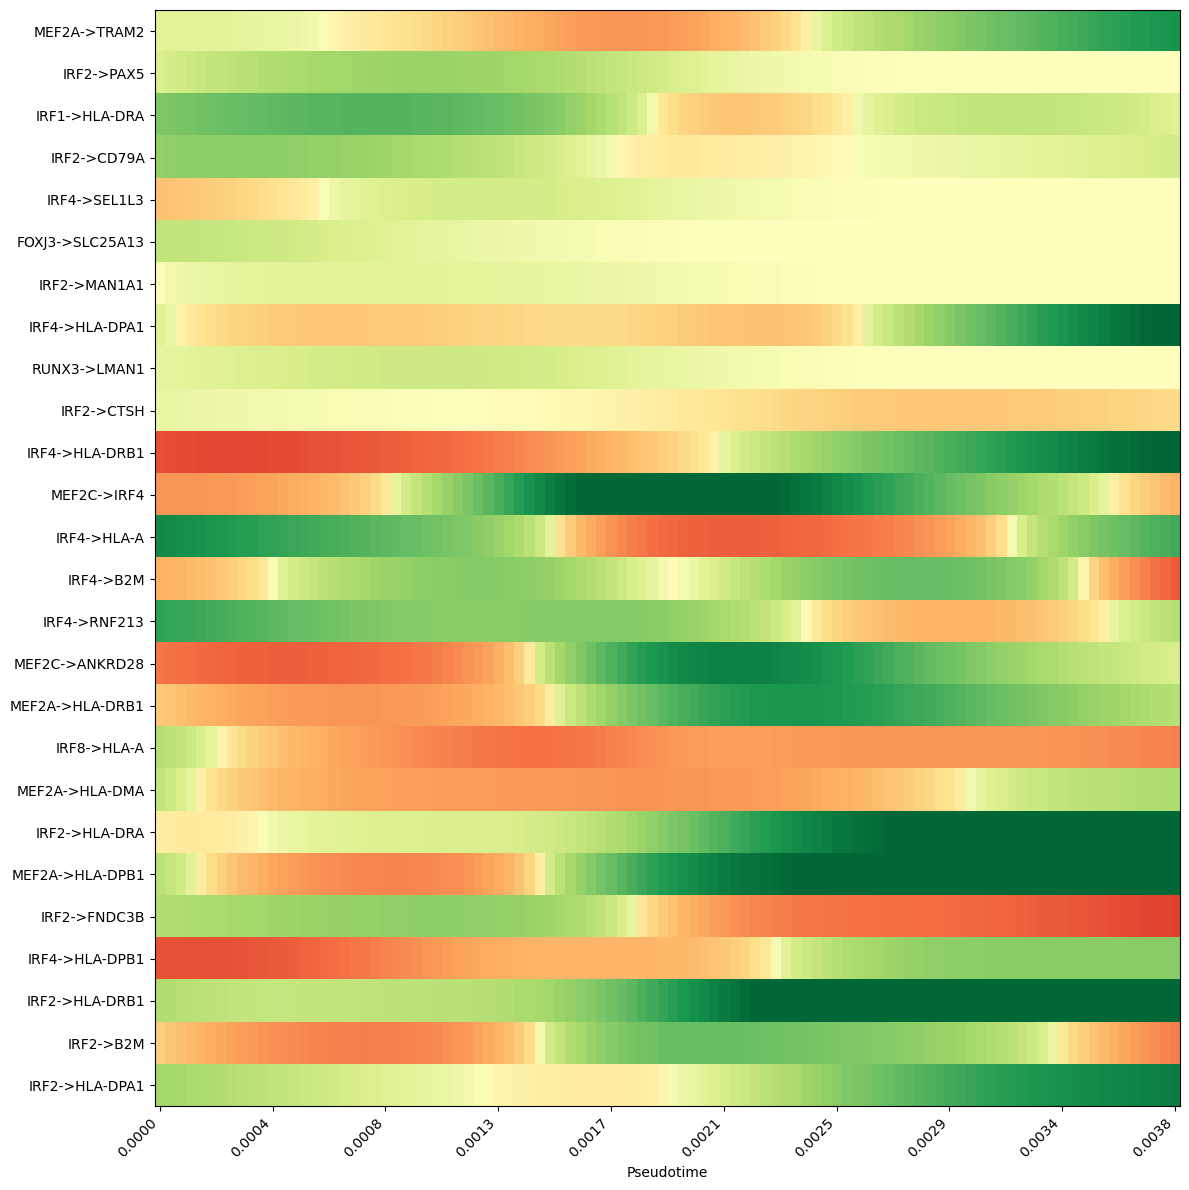

In [84]:
fig, ax, force_values = plot_force_heatmap(
    force_df=least_similar_forces_pb,
    dtime=dtime_pb,
    figsize=(12, 12),
    cmap='RdYlGn'
)